In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext rpy2.ipython

import copy
import itertools
import matplotlib.pyplot as plt
import MESS
import numpy as np
import pandas as pd
import random
import toytree

from collections import Counter

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [29]:
def bm(mean, var, log=True):
    # Avoid log(1)
    if not log or mean <= 1:
        return np.round(np.random.normal(mean, var))
    else:
        return np.round(np.exp(np.random.normal(np.log(mean), var)))

def prune(tre, verbose=False):
    tips = tre.treenode.get_leaves()
    
    if np.any(np.array([x.height for x in tips]) > 0):
        for t in tips:
            if not np.isclose(t.height, 0):
                if verbose: print("Removing node/height {}/{}".format(t.name, t.height))
                t.delete(prevent_nondicotomic=False)
                prune(tre)

bm(10, .1, log=True)


9.0

In [4]:
# This works, but the notion of time is fucked up, it's not
# per lineage, it's per birth event.
def bd_timesteps(steps=50, abundance=500000):
    tre = toytree.tree()
    tre.treenode.add_feature("abundance", abundance)

    for s in range(steps):
        tips = tre.treenode.get_leaves()

        # Check extinction
        for x in tips:
            if x.abundance <= 0:
                x.delete(preserve_branch_length=True, prevent_nondicotomic=False)

        tips = tre.treenode.get_leaves()
        sp = np.random.choice(tips)
        #sp.dist += 1
        c1 = sp.add_child(name=str(s)+"1", dist=0)
        c2 = sp.add_child(name=str(s)+"2", dist=0)
        abund = np.random.randint(1, sp.abundance)
        c1.add_feature("abundance", abund)
        c2.add_feature("abundance", sp.abundance-abund)

        # Update branch length and perturb abundance
        for x in tips:
            x.dist += 1
            x.abundance = bm(x.abundance, 100, log=False)

        prune(tre)
    return tre
tre = bd_timesteps()
tre.draw()

(<toyplot.canvas.Canvas at 0x7f52c41509b0>,
 <toyplot.coordinates.Cartesian at 0x7f536e642a20>)

<svg class="toyplot-canvas-Canvas" height="702.0px" id="tf98cd4a3ece445699758b359695fbf80" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 265.0 702.0" width="265.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 432 431 371 201 361 412 482 481 442 441 332 331 52 422 421 302 301 291 192 381 242 282 281 181 272 461 171 112 392 391 252 352 222 472 492 491 151 402 401

# bd todos
Should we implement a death rate parameter too? If ancestral abundance is super high
which we'd expect if we're dividing at each branch, then the extinction rate is really low
* Maybe not, maybe it's cool because the ancestral species should have a reasonable abundance

In [145]:
# Should we implement a death rate parameter too? If ancestral abundance is super high
# which we'd expect if we're dividing at each branch, then the extinction rate is really
# low
def bd_rate(b=1, stop="taxa", n=50, t=4, sigma=1, abundance=5000000, verbose=False):
    tre = toytree.tree()
    tre.treenode.add_feature("abundance", abundance)

    taxa_stop = n
    time_stop = t

    ext = 0
    evnts = 0
    t = 0
    while(1):
        tips = tre.treenode.get_leaves()
        # Check extinction
        for x in tips:
            if x.abundance <= 0:
                x.delete(preserve_branch_length=True, prevent_nondicotomic=False)
                ext += 1
        prune(tre)

        ## Get list of extant tips
        tips = tre.treenode.get_leaves()

        # Check stopping criterion
        done = False
        if stop == "taxa":
            if len(tips) >= taxa_stop:
                done = True
        elif stop == "time":
            if t >= time_stop:
                done = True
        elif len(tips) == 0:
            print("All lineages extinct")
            done = True
        if done:
            if verbose:
                print("Time {}".format(t))
                print("Ntips {}".format(len(tips)))
                print("Birth events {}".format(evnts))
                print("Extinctions (per birth) {} ({})".format(ext, ext/evnts))
            tre._coords.update()
            return tre

        # Sample time interval
        dt = np.random.exponential(1/(len(tips) * b))
        t = t + dt
        evnts += 1
        #print("{}".format(t))
        
        sp = np.random.choice(tips)
        c1 = sp.add_child(name=str(t)+"1", dist=0)
        c2 = sp.add_child(name=str(t)+"2", dist=0)
        try:
            # Always have at least 1 individual for each daughter species
            abund = np.random.randint(1, sp.abundance)
        except Exception as inst:
            # If a species of abundance 1 speciates we need to allow this
            sp.abundance = 2
            if verbose: print("abund failed {}".format(sp.abundance))
        c1.add_feature("abundance", abund)
        c2.add_feature("abundance", sp.abundance-abund)

        # Update branch length and perturb abundance
        tips = tre.treenode.get_leaves()
        for x in tips:
            x.dist += dt
            x.abundance = bm(x.abundance, sigma, log=True)

        #tips = tre.treenode.get_leaves()
        #print([x.abundance for x in tips])
        #tre.draw()

tre = bd_rate(b=.2, stop="taxa", n=50, t=4, sigma=0.5, abundance=10000, verbose=True)

try:
    tre.draw()
except Exception as inst:
    import traceback
    # Iff one species remains and you try to 'draw()' you get this error
    # can generate by setting abundance very low. not sure why it's doing this yet.
    # 'list' object has no attribute 'shape'
    print(traceback.print_exception(inst))
    print([x.name for x in tre.treenode.get_leaves()])

abund failed 2
abund failed 2
abund failed 2
Time 32.20872824221545
Ntips 50
Birth events 71
Extinctions (per birth) 22 (0.30985915492957744)


<svg class="toyplot-canvas-Canvas" height="900.0px" id="t911a9489163246b6b4d84194fe1e8937" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 345.0 900.0" width="345.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 31.0341007757746682 31.0341007757746681 30.202404514578641 31.0896363078632872 31.0896363078632871 31.1838913067593422 31.7877311283829622 32.15101407534912 32.15101407534911 30.899504366960961 30.4775896956751422 30.4775896956751421 28.6367442619872141 31.851406434548442 31.851406434548441 29.4354157387666361 21.1897000892317562 25.8036202140436221 26.038195150191332 27.2896553676595952 27.2896553676595951 30.920201166717292 30.920201166717291 24.5031515903324572 24.5031515903324571 30.714116305603772 30.714116305603771 30.746951519628492 30.746951519628491 20.276507283591792 32.208728242215452 32.208728242215451 31.194959790139531 30.0730284738991931 28.7129814910067152 30.094726005664822 30.094726005664821 29.6031697421662762 32.198041326353912 32.198041326353911 30.1626971450542421 32.0191887653333752 32.0191887653333751 32.089119443677262 32.089119443677261 30.858181905551631 29.4609454639313562 30.1976449232574672 31.322362462653032 31.322362462653031

In [158]:
#sups = tre.get_node_values("abundance", show_root=False, show_tips=False)
tips = tre.treenode.get_leaves()
abunds = [str(x.abundance) for x in tips]
tre.draw(tip_labels=abunds)

['31.0341007757746682', '31.0341007757746681', '30.202404514578641', '31.0896363078632872', '31.0896363078632871', '31.1838913067593422', '31.7877311283829622', '32.15101407534912', '32.15101407534911', '30.899504366960961', '30.4775896956751422', '30.4775896956751421', '28.6367442619872141', '31.851406434548442', '31.851406434548441', '29.4354157387666361', '21.1897000892317562', '25.8036202140436221', '26.038195150191332', '27.2896553676595952', '27.2896553676595951', '30.920201166717292', '30.920201166717291', '24.5031515903324572', '24.5031515903324571', '30.714116305603772', '30.714116305603771', '30.746951519628492', '30.746951519628491', '20.276507283591792', '32.208728242215452', '32.208728242215451', '31.194959790139531', '30.0730284738991931', '28.7129814910067152', '30.094726005664822', '30.094726005664821', '29.6031697421662762', '32.198041326353912', '32.198041326353911', '30.1626971450542421', '32.0191887653333752', '32.0191887653333751', '32.089119443677262', '32.0891194

(<toyplot.canvas.Canvas at 0x7f52a745b128>,
 <toyplot.coordinates.Cartesian at 0x7f52a74ce470>)

<svg class="toyplot-canvas-Canvas" height="900.0px" id="td347eb4177be46738db3f24c47efa27a" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 295.0 900.0" width="295.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 7.0 14.0 13.0 451.0 64.0 1390.0 563.0 437.0 94.0 192.0 4.0 19.0 30758.0 2692139.0 2271793.0 4479802.0 3.0 2.0 82.0 31.0 100.0 64.0 1291.0 61.0 455.0 23239.0 6.0 24130.0 15678.0 27.0 3.0 984.0 1002.0 23935.0 234.0 22914.0 32932.0 10.0 9.0 142.0 11.0 25.0 24.0 43.0 15.0 504.0 64.0 1.0 1.0 46.0

abund failed 2
abund failed 2
abund failed 2
abund failed 2
Time 14.550188421031532
Ntips 50
Birth events 71
Extinctions (per birth) 22 (0.30985915492957744)
abund failed 2
abund failed 2
Time 23.66572254487124
Ntips 50
Birth events 64
Extinctions (per birth) 15 (0.234375)
abund failed 2
Time 24.065617379633334
Ntips 50
Birth events 55
Extinctions (per birth) 6 (0.10909090909090909)
abund failed 2
abund failed 2
abund failed 2
abund failed 2
Time 27.78775854344348
Ntips 50
Birth events 74
Extinctions (per birth) 25 (0.33783783783783783)
abund failed 2
abund failed 2
abund failed 2
abund failed 2
Time 29.768238463890118
Ntips 50
Birth events 74
Extinctions (per birth) 25 (0.33783783783783783)
abund failed 2
abund failed 2
abund failed 2
abund failed 2
abund failed 2
Time 37.20459623107657
Ntips 50
Birth events 89
Extinctions (per birth) 40 (0.449438202247191)
abund failed 2
Time 20.841340951073356
Ntips 50
Birth events 55
Extinctions (per birth) 6 (0.10909090909090909)
abund failed 2
Ti

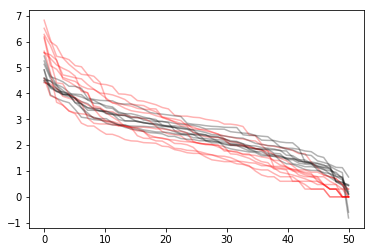

In [144]:
for _ in range(10):
    
    tre = bd_rate(b=.2, stop="taxa", n=50, t=4, sigma=0.5, abundance=10000, verbose=False)
    tips = tre.treenode.get_leaves()
    abunds = np.array([x.abundance for x in tips])
    #plt.hist(np.log10(abunds), bins=20)
    abunds = sorted(abunds, reverse=True)
    xs = np.linspace(0, len(abunds), len(abunds))
    ys = np.log10(abunds)
    plt.plot(xs, ys, c="red", alpha=0.3)

    plt.plot(xs, np.log(sorted(np.random.lognormal(2.5, 1, len(abunds)), reverse=True)), c='black', alpha=0.3)

## New nodes still don't have idx

## Trash below here

In [267]:
%%R
rexp(20, 10)

 [1] 0.44219855 0.03608151 0.06805857 0.07579760 0.22339966 0.10209516
 [7] 0.12705568 0.05505301 0.12929021 0.15964229 0.09088534 0.01934587
[13] 0.02880004 0.03312176 0.15023076 0.16136473 0.01010390 0.03459232
[19] 0.04028929 0.10390063
